# Hybrid LSTM-GRU Anomaly Detection

This notebook trains the **Hybrid LSTM-GRU** model on wESAD (synthetic) data for the Antigravity project.

**Architecture:**
*   Input: [Batch, 60, 4] (Heart Rate, HRV, SpO2, Motion)
*   Layers: 2 LSTM + 2 GRU
*   Output: Binary Classification (Normal vs Anomaly)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

# Set Random Seed
torch.manual_seed(42)
np.random.seed(42)

## 1. Load & Preprocess Data

In [3]:
SEQUENCE_LENGTH = 60
BATCH_SIZE = 32

def generate_synthetic_data():
    print("Generating Synthetic WESAD Sequences...")
    rng = np.random.RandomState(42)
    
    X_data = []
    y_data = []
    
    # Generate 1000 sequences
    for _ in range(1000):
        label = 0 if rng.rand() > 0.5 else 1 # 0=Normal, 1=Anomaly
        
        seq = []
        for _ in range(SEQUENCE_LENGTH):
            if label == 0: # Normal
                hr = rng.normal(70, 5)
                hrv = rng.normal(50, 10)
                spo2 = rng.normal(98, 1)
                motion = rng.normal(0, 0.1)
            else: # Anomaly
                hr = rng.normal(110, 15)
                hrv = rng.normal(20, 5)
                spo2 = rng.normal(95, 2)
                motion = rng.normal(0, 0.5)
            
            seq.append([hr, hrv, spo2, motion])
        
        X_data.append(seq)
        y_data.append(label)
            
    X = np.array(X_data, dtype=np.float32) # Shape: [1000, 60, 4]
    y = np.array(y_data, dtype=np.int64)
    return X, y

X, y = generate_synthetic_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Generating Synthetic WESAD Sequences...
Training Data Shape: (800, 60, 4)
Testing Data Shape: (200, 60, 4)


## 2. Define Hybrid LSTM-GRU Model

In [4]:
class HybridLSTM_GRU(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_classes=2):
        super(HybridLSTM_GRU, self).__init__()
        
        # Two LSTM Layers
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=0.3)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.3)
        
        # Two GRU Layers
        self.gru1 = nn.GRU(hidden_dim, hidden_dim, batch_first=True, dropout=0.3)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim, batch_first=True, dropout=0.3)
        
        # Dense Output
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # LSTM Layers
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        
        # GRU Layers
        out, _ = self.gru1(out)
        out, _ = self.gru2(out) 
        
        # Take the output of the last time step
        out = out[:, -1, :]
        
        # Classification
        out = self.fc(out)
        return self.softmax(out)

## 3. Train Model

C:\Users\priya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Starting Training...
Epoch 1/10, Loss: 0.3219
Epoch 2/10, Loss: 0.0021
Epoch 3/10, Loss: 0.0010
Epoch 4/10, Loss: 0.0007
Epoch 5/10, Loss: 0.0006
Epoch 6/10, Loss: 0.0005
Epoch 7/10, Loss: 0.0004
Epoch 8/10, Loss: 0.0003
Epoch 9/10, Loss: 0.0003
Epoch 10/10, Loss: 0.0002


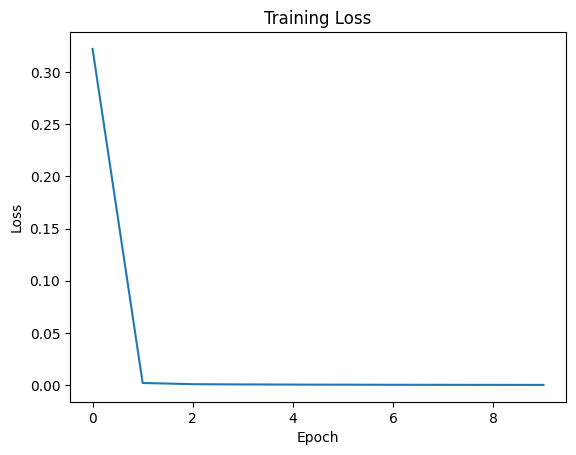

In [5]:
# Convert to Tensors
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

model = HybridLSTM_GRU()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history = []
EPOCHS = 10

print("Starting Training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss/len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 4. Evaluation & Confusion Matrix

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        97
     Anomaly       1.00      1.00      1.00       103

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



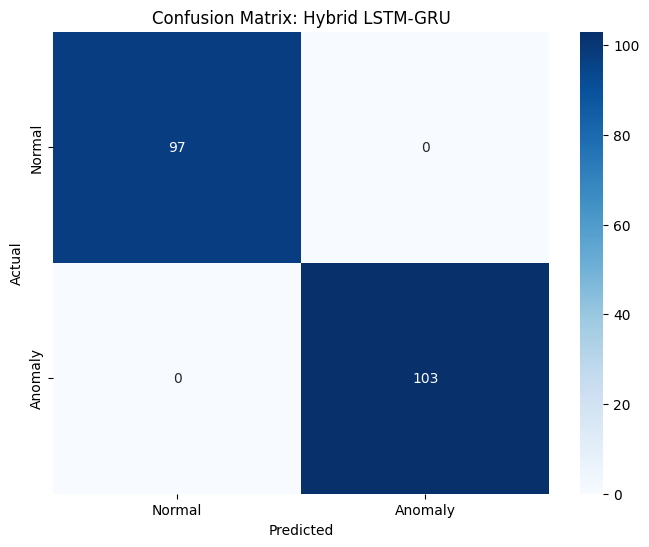

In [6]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=['Normal', 'Anomaly']))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix: Hybrid LSTM-GRU')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()